# 06. PyTorch Transfer Learning

Let's take a well performing pre-trained model and adjust it to one of our own problems.

We can increase the performance of our model by getting a help from other already trained good models.

**What we're going to cover**
- take a pretrained model from `torchvision.models`
- and customize it to work on (and hopefully improve) our `foodvision` problem

Steps that we will do:
1. Setting up
2. Get data
3. Create datasets ad dataloaders
4. Get and Customize a pretrained model
5. Train model
6. Evaluate the model by plotting loss curves
7. Make predictions on images from the test set

## 1. Setting up

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split('.')[0]) >=2, 'torch version should be 2.0+'
    assert int(torchvision.__version__.split('.')[1]) >=17, 'torchvision version should be 0.17+'
    print(f'torch version: {torch.__version__}')
    print(f'torchvision version: {torchvision.__version__}')
except:
    print('[INFO] torch/torchvision verson not as required, installing nightly versions')
    !pip install -U torch torchvision
    import torch
    import torchvision
    print(f'torch version: {torch.__version__}')
    print(f'torchvision version: {torchvision.__version__}')
    

torch version: 2.2.2
torchvision version: 0.17.2


In [20]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms

# try torchinfo, install if not installed
try:
    from torchinfo import summary
except:
    print(f"[INFO] Couldn't find torchinfo, intalling it.")
    !pip install -q torchinfo
    print(f'installed torchinfo {torchinfo.__version__}')
    from torchinfo import summary

## setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 2. Getting Data

before we start transfer learning, we need a dataset.


In [3]:
from pathlib import Path
from zipfile import ZipFile
import requests
import os

data_url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"

data_path = Path('data')
image_data_path = data_path / 'pizza_steak_sushi'

# create folders if not already available
if image_data_path.is_dir():
    print('folders already eists')
else:
    print("Folders doesn't exist, creating one..")
    image_data_path.mkdir(parents=True, exist_ok=True)

    # download data
    with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
        request = requests.get(data_url)
        print(f'Downloading data...')
        f.write(request.content)
        print(f'Download done.')
    # unzip
    with ZipFile(data_path/'pizza_steak_sushi.zip', 'r') as zip_file:
        print(f'Unzipping...')
        zip_file.extractall(image_data_path)
        print('Extracted..')
    # remove zip file
    os.remove(data_path/'pizza_steak_sushi.zip')


folders already eists


## 3. Create datasets and dataloader
now that we have downloaded the data we should create `datasets` and corresponding `dataloader`

### 3.1 Creating a transform for torchvision.models (manual = old method)

since we'll be using a pretrained model from `torchvision.models`, there's a specific transform we need to prepare our images first.

When using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model**

1. All pretrained models expect input images normalized in the same way, i.e. `mini batches` of 3-channel images of shape (3 x H x W) where H and W are expected to be at least 224.
    - But some models might expect H and W to be of other sizes. We have to check the documentation for that.
2. Images have to be loaded in to a range of [0,1[
3. then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`

we can achieve this in the following way.

In [4]:
manual_transform = transforms.Compose([
    transforms.Resize(size=(224,224)), # mini batchs of shape 3,224,224
    transforms.ToTensor(), # turn image values to between 0, 1
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    )
])

In [5]:
train_data_path = data_path / 'pizza_steak_sushi'/ 'train'
test_data_path = data_path / 'pizza_steak_sushi'/ 'test'

train_data_path, test_data_path

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [6]:
train_data = torchvision.datasets.ImageFolder(root=train_data_path,
                                              transform=manual_transform,
                                              target_transform=None)
test_data = torchvision.datasets.ImageFolder(root=test_data_path,
                                              transform=manual_transform,
                                              target_transform=None)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = torch.utils.data.DataLoader(dataset=train_data,
                                               batch_size=BATCH_SIZE,
                                               num_workers=NUM_WORKERS,
                                               shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_data,
                                               batch_size=BATCH_SIZE,
                                               num_workers=NUM_WORKERS,
                                               shuffle=False)
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

### 3.2 Creating a transform for `torchvision.models` - new method

As of `torchvision v0.13+`, an automatic transform creation feature has been added.

When you setup a model from `torchvision.models` 

select a pretrained model weights you'd like to use

for example:

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

where,
- `EfficientNet_B0_Weights` is the model architecture weights we'd like to use
- `DEFAULT` means the best available weights (the best performance in ImageNet)
  - Depending on the model architecture we can also see 'IMAGENET_V1` and `IMAGENET_V2`, where generally the higher version number is better.
  - `DEFAULT` is easiest option to choose.

let's try it out

In [7]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

Now we have access to the transform associated with the `EfficientNet_BO_Weights model`

In [8]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

The benefit of using auto transform is that, it `comes` with the `model architecture` we chose to use.

we don't have to create it by hand.

In [9]:
train_data = torchvision.datasets.ImageFolder(root=train_data_path,
                                              transform=auto_transforms,
                                              target_transform=None)
test_data = torchvision.datasets.ImageFolder(root=test_data_path,
                                              transform=auto_transforms,
                                              target_transform=None)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = torch.utils.data.DataLoader(dataset=train_data,
                                               batch_size=BATCH_SIZE,
                                               num_workers=NUM_WORKERS,
                                               shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_data,
                                               batch_size=BATCH_SIZE,
                                               num_workers=NUM_WORKERS,
                                               shuffle=False)
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

## 4. Getting a pretrained model

Over the past few notebooks, we'be been building PyTorch neural networks from scratch.

and while that's a good skill to have our model is not performing well enough.

In order for our model to perform well, we can use `Transfer Learning`

The whole idea of transfer learning is to **take an already well-performing model on a problem-space similar to yours and then customizing it to your own use case**

since we're working on a computer vision problem, we can find the pretrained models in `torchvision.models`

### 4.1 Which pretrained model should you use?
it depends on your problem/the device you are working with.

Generally, the higher number in the model name (e.g. efficientnet_b0() -> efficientnet_b1() -> efficientnet_b7()) means *better performance but a larget model.*

**You might think better performance is always better, right?**

That's true but **some better performing models are too big to some devices**

so we should choose the one that would be better for us and our device to use.

But if we can use unlimited compute power then we can take *the biggest, most compute hungry model.*

Understanding this **performance vs. speed vs. size tradeoff** will come with time and practice

As of May 2022, [Nutrify](https://nutrify.app/) (the machine learning powered app Daniel Bourke is working on) is powered by an efficientnet_b0.

[Comma.ai](https://comma.ai/) (a company that makes open source self-driving car software) uses an [`efficientnet_b2`](https://geohot.github.io/blog/jekyll/update/2021/10/29/an-architecture-for-life.html) to learn a representation of the road.

> **Note**: Even though we're using `efficientnet_bX`, it's important not to get too attached to any one architecture, as they are always changing as new research gets released.
>
> Best to experiment, experiment, experiment and see what works for your problem.

### 4.2 Setting up a pretrained model
The pretrained model we're going to be using is `torchvision.models.efficientnet_b0()`

the architecture is from the paper [EfficientNet](https://arxiv.org/abs/1905.11946)

![](efficient_net_architecture.png)

we can setup the `EfficientNet_B0` pretrained ImageNet weights using the same code as we uded to create the transform.

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT = best available weights for ImageNet

This means model has already been trained on millions of images and has a good base representation of image data.

**The PyTorch version of this pretrained model is capable of achieving ~77.7% accuracy across ImageNet's 1000 classes.**

In [10]:
# setup the model with pretrained weights and send it to the target device
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [11]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

if we print the model, we get something similar to the following:
![](effientnetB0_backbone.png)

lots and lots of layers

This is one of the benefits of transfer learning
- taking an existing model, that's been crafted by some of the best enginners in the world
- and apply to your own problem.

The efficientnet_b0 comes in three main parts
1. `features`
2. `avgpool`
3. `classifier`

1. `features` - a collection of convolutional layers and other various activation layers to learn a base representation of vision data( this base representation/collection of layers is often referred to as **features** or **feature extractor**, "the base layers of the model learns the different features of images")
2. `avgpool` - Takes the average of the output of the `features` layer(s) and turns it into a `feature vector`
3. `classifier` - Turns the `feature vector` into a vector with the same dimensionality as the number of required output classes (since `efficientnet_b0` is pretrained on ImageNet and because ImageNet has 1000 classes, `out_features=1000` is the default)

### 4.3. Getting a summary of our model with `torchinfo.summary()`

To get the info, we pass in:
- `model` - the model we'd like to get a summary of
- `input_size` - the shape of the data we'd like to pass to our model
- `col_names` - the various information columns we'd like to see about our model
- `col_width` - how wide the columns should be for the summary
- `row_settings` - what features to show in a row

In [12]:
summary(model=model,
        input_size=(32,3,224,224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        # row_settings=['var_names']
       )

Layer (type:depth-idx)                                  Input Shape          Output Shape         Param #              Trainable
EfficientNet                                            [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential: 1-1                                       [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential: 2-2                                  [32, 32, 112, 112]   [32, 16, 112, 112]   --                   True
│    

From the output summary, we can see all of the various input and output shape changes as our image data goes through the model.

and there are a whole bunch more total parameters (pre-trained weights) to recognize different patterns in our data.

for reference, our model from the previous sections, **TinyVGG had 8,033 parameters vs 5,288,548 parameters for `efficientnet_b0`, an increase of ~654x!**

### 4.4 Freezing the base model and changing the output layer to suit our needs

The process of transfer learning usually goes:
- `freeze` some `base layers` of a pretrained model (typically the `features` section)
- and then `adjust the output layers`(also called `head/classifier layers`) to suit your needs

![](06-v2-effnet-changing-the-classifier-head.png)

You can customize the outputs of a pretrained model by changing the output layers to suit your problem. 

The original `torchvision.models.efficientnet_b0()` comes with `out_features=1000` because there are 1000 classes in ImageNet, the dataset it was trained on. However, for our problem, classifying images of pizza, steak and sushi we only need `out_features=3`

Let's freeze all of the layers/parameters in the `features1 section of our `efficientnet_b0` model.

- To Freeze layers means to keep them how they are during training. In essence, we'd like to keep the pre-trained of the efficientnet model learned from ImageNet as a backbone and then only change the output layers.

We can free all the layers/parameters in the `features` section by setting the attribute `requires_grad=False`

For parameters with `requires_grad=False`, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with `requires_grad=False` is  'untrainable' or 'frozen' in place



In [13]:
# freeze all base layers in the 'features' section of the model
for param in model.features.parameters():
    param.requires_grad = False

Now all the feature extractor layers are frozen.

Let's now adjust the output layer or the `classifier` portion of our pretrained model to our needs.

we will change `out_features=1000` to `out_features=3`


In [14]:
# set the manual seeds
torch.manual_seed(42)

# get the length of class_names
output_shape = len(class_names)

# recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)
).to(device)

Nice, now lets check our model summary.

In [15]:
summary(model=model,
        input_size=(32,3,224,224),
        row_settings=['var_names'],
        col_names=['input_size', 'output_size','num_params', 'trainable'],
        col_width=20
       )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

![](06-torchinfo-summary-frozen-layers.png)

**Note**: The more trainable parameters a model has, the more compute power/longer it takes to train. Freezing the base layers of our odel and leaving it with less trainable parameters means ourmodel should train quite quickly. This is `one huge benefit of transfer learning`, taking the already learned parameters of a model trained on a problem similar to ours and only tweaking the outputs slightly to suit out problem.

## 5. Train Model
Now we've got a pretrained model that's semi-frozen and has a customized `classifier`, lets see `transfer learning` in action

To begin the training, as usual we need `loss function` and the `optimizer`

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

def accuracy_fn(y_true, y_pred):
    # print(y_true)
    # print(y_pred)
    total_equal = (y_true==y_pred).sum()
    return total_equal / len(y_pred)

Lets train the model now

In [17]:
from tqdm import tqdm
# set the random seed
torch.manual_seed(42)

#start timer
from timeit import default_timer as timer
start_time = timer()

EPOCHS = 5
results = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}
for epoch in tqdm(range(EPOCHS)):
    total_train_loss, total_train_acc = 0,0
    for batch_size, (X,y) in enumerate(train_dataloader):
        model.train()

        # forward pass
        y_logits = model(X)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        
        # loss
        loss = loss_fn(y_logits, y)
        accuracy = accuracy_fn(y_true=y, y_pred=y_pred)
        
        # optimizer zero grad
        optimizer.zero_grad()
        # loss backward
        loss.backward()
        # optimizer step
        optimizer.step()
        total_train_loss += loss
        total_train_acc += accuracy
    total_train_loss/=len(train_dataloader)
    total_train_acc/=len(train_dataloader)

    model.eval()
    with torch.inference_mode():
        total_test_loss, total_test_acc = 0, 0
        for X,y in test_dataloader:
            # forward pass
            y_logits = model(X)
            y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
            # loss
            loss = loss_fn(y_logits, y)
            accuracy = accuracy_fn(y_true=y, y_pred=y_pred)
            total_test_loss+=loss
            total_test_acc+=accuracy
        total_test_loss/=len(test_dataloader)
        total_test_acc/=len(test_dataloader)
    results['train_loss'].append(total_train_loss.item())
    results['train_acc'].append(total_train_acc.item())
    results['test_loss'].append(total_test_loss.item())
    results['test_acc'].append(total_test_acc.item())
    print(f'Epoch {epoch} | train loss: {total_train_loss} acc: {total_train_acc} | test loss: {total_test_loss} acc: {total_test_acc}')
end_time = timer()
print(f'[INFO] Total training time: {end_time - start_time:.3f} seconds')

 20%|██████████████████████████████                                                                                                                        | 1/5 [01:17<05:09, 77.37s/it]

Epoch 0 | train loss: 1.0977482795715332 acc: 0.3828125 | test loss: 0.885552704334259 acc: 0.6827651858329773


 40%|████████████████████████████████████████████████████████████                                                                                          | 2/5 [02:34<03:51, 77.32s/it]

Epoch 1 | train loss: 0.9210745096206665 acc: 0.65625 | test loss: 0.7919705510139465 acc: 0.8257575631141663


 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                            | 3/5 [03:52<02:34, 77.43s/it]

Epoch 2 | train loss: 0.755328893661499 acc: 0.8671875 | test loss: 0.6486082077026367 acc: 0.9166666865348816


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 4/5 [05:09<01:17, 77.39s/it]

Epoch 3 | train loss: 0.737601101398468 acc: 0.70703125 | test loss: 0.5954256653785706 acc: 0.8958333134651184


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:26<00:00, 77.38s/it]

Epoch 4 | train loss: 0.6271634101867676 acc: 0.765625 | test loss: 0.6105523705482483 acc: 0.8967803120613098
[INFO] Total training time: 386.938 seconds


with `efficientnet_b0` backbone, our model achieves almost 85%+ accuracy on the test dataset.

Not bad for a model we downloaded with a few lines of code.

## 6. Evaluate model by plotting loss curves

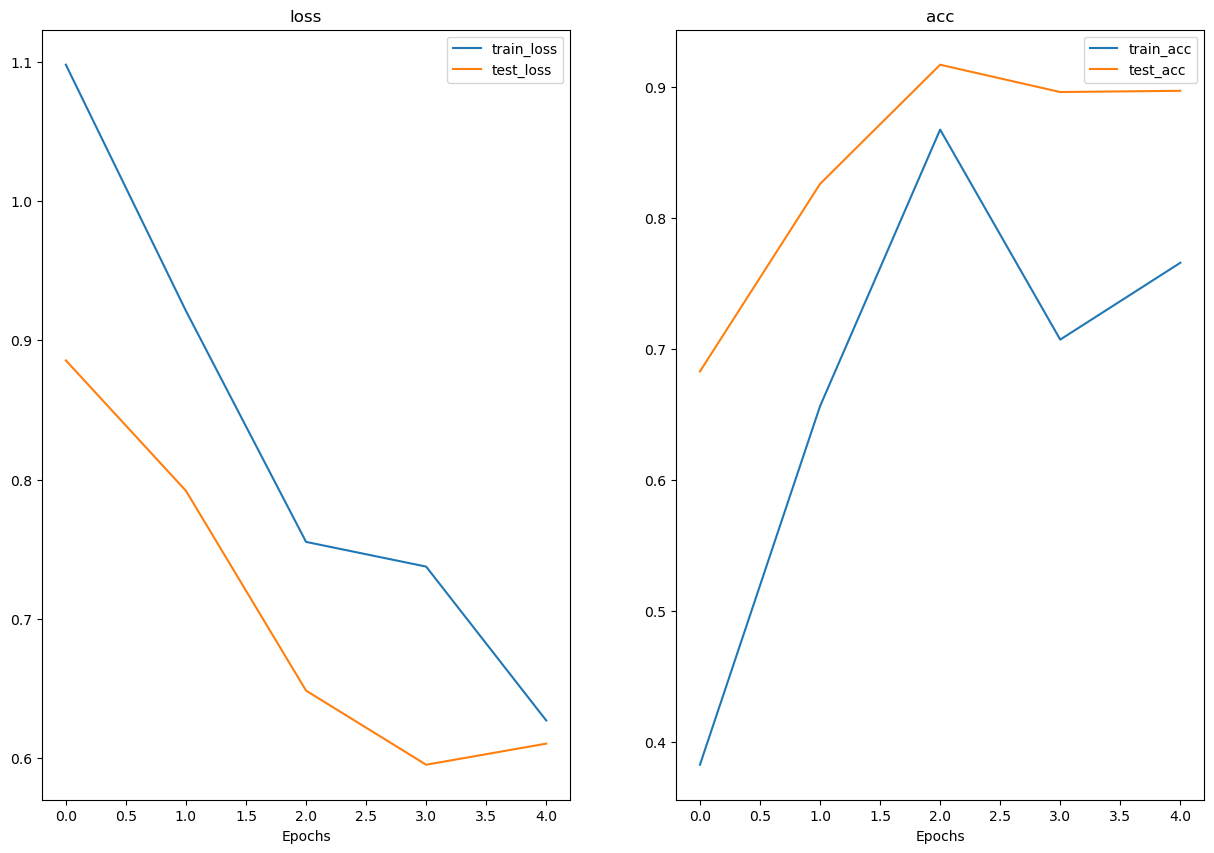

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(results['train_loss'], label='train_loss')
plt.plot(results['test_loss'], label='test_loss')
plt.title('loss')
plt.xlabel('Epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(results['train_acc'], label='train_acc')
plt.plot(results['test_acc'], label='test_acc')
plt.title('acc')
plt.xlabel('Epochs')
plt.legend();

looks like both loss and acc are going in the right direction.

This is the power of transfer learning. Using a pretrained model often leads to pretty good results with a small amounts of data in less time.

## 7. Make predictions on images from the test set

It looks like our model performs well quantitatively but how about qualitatively?

let's find out by making some predictions with our model on images from the test set and plotting them.

One thing we'll have to remember is that, for our model to make predictions on an image, the image has to be in same formast as the images our model was trained on.

this means we'll need to make sure our images have:
- **Same shape**
- **Same datatype**
- **Same device**
- **Same transformations**

In [53]:
from PIL import Image
from typing import List, Tuple

def pred_and_plot_img(model: nn.Module,
                      img_path: str,
                      class_names: List[str],
                      image_size: Tuple[int, int] = (224,224),
                      transform: torchvision.transforms = auto_transforms,
                      device:torch.device=device):
    
    img = Image.open(img_path)
    
    # transform the image
    transformed_image = transform(img)
    
    # send to the device
    transformed_image = transformed_image.to(device)
    
    # eval the image
    model.eval()
    with torch.inference_mode():
        # add extra dimention to the transformed image
        transformed_image = transformed_image.unsqueeze(0).to(device)
    
        # make prediction on the transformed image
        pred_logits = model(transformed_image)
        pred_proba = torch.softmax(pred_logits, dim=1)
        pred_label = pred_proba.argmax(dim=1)
    
        # plot the image with predicted label and probability
        plt.figure()
        plt.imshow(img)
        plt.title(f'Pred: {class_names[pred_label]} | Prob: {pred_proba.max():.3f}')
        plt.axis(False)

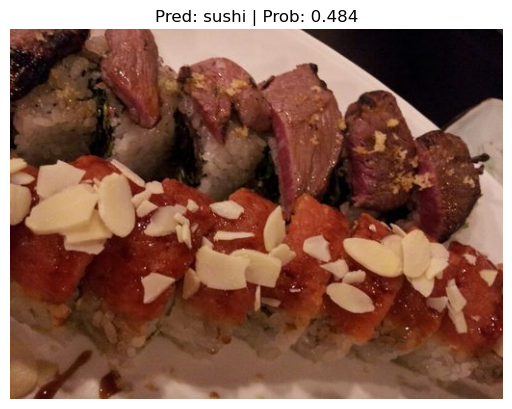

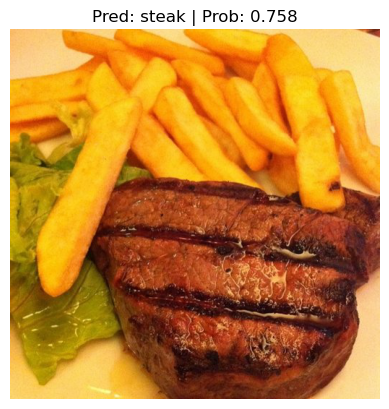

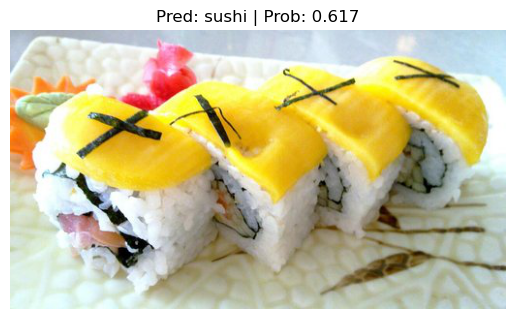

In [55]:
test_images_path = list(data_path.glob('*/test/*/*.jpg'))

# select random path
import random
random.seed(42)

random_image_path = random.choices(test_images_path, k=3)


for img_path in random_image_path:
    pred_and_plot_img(model=model,
                      img_path=img_path,
                      class_names=class_names,
                      image_size=(224,224),
                      transform=auto_transforms,
                      device=device)

### Making Predictions on a custom image

let's see how our model does on our won custom image.

**This is wehre the real fun of a machine learning is**

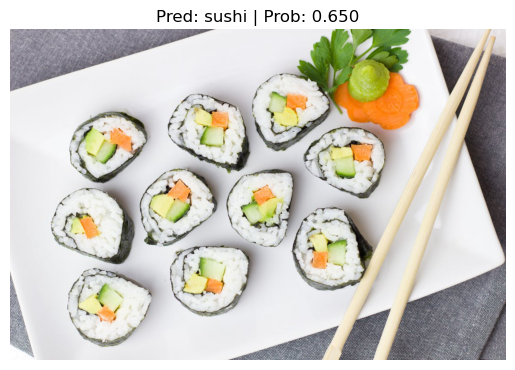

In [65]:
custom_image_path = data_path / 'pexels_photo_357756.jpeg'

# pred and plot custom image
pred_and_plot_img(model=model,
                  img_path=custom_image_path,
                  class_names=class_names,
                  image_size=(224,224),
                  transform=auto_transforms,
                  device=device)

That's correct. This is an image of a sushi.

This indicates that `efficientnet_b0` model is a good model, and does better than guessing.

Let's try another one

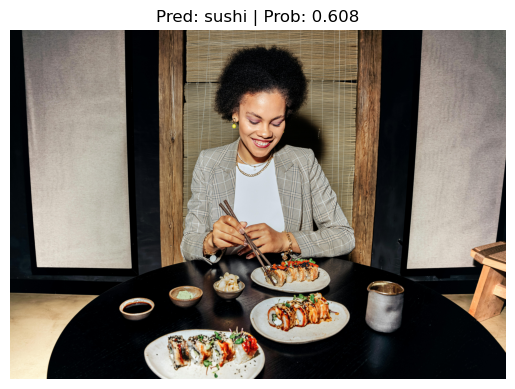

In [66]:
custom_image_path = data_path / 'sushi_eating.jpg'

# pred and plot custom image
pred_and_plot_img(model=model,
                  img_path=custom_image_path,
                  class_names=class_names,
                  image_size=(224,224),
                  transform=auto_transforms,
                  device=device)

That's correct.

## Main Takeaways
- `Transfer Learning` allows us to get a good results with a relatively small amount of custom data.
- Knowing the power of transfer learning, it's a good idea to ask at the start of every problem, **Does an existing well-performing model exist for my problem?**
- While using a pretrained model, it is important that our `custom data be formatted/preprocessed` in the same way that the original model was trained on otherwise we might get a degraded performance.
- The same goes for predicting on a custom data, we should ensure the custom data is in the same format as the data our model was trained on.
- We can find several pre-trained model on `PyTorch domain libraries`, `huggingface hub` and libraries sush as `timm`(PyTorch image models)